# 1. Setup

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import RandomizedSearchCV
import dalex as dx


from sklearn.model_selection import train_test_split, StratifiedKFold
import shap
from sklearn.metrics import classification_report, confusion_matrix
import xgboost as xgb
import shap
from xgboost import XGBClassifier
from sklearn.inspection import permutation_importance
from sklearn.inspection import PartialDependenceDisplay

sns.set_theme(style="whitegrid")

# 2. Load Dataset

In [9]:
df_train = pd.read_csv('./dataset.csv')
X_train_full = df_train.iloc[:,1:].drop('target_variable', axis=1)

y_train_full = df_train['target_variable']

In [10]:
# Dividir el conjunto de datos en entrenamiento y prueba
# probaremos con un 20% para test
X_train, X_test, y_train, y_test = train_test_split(
    X_train_full,
    y_train_full,
    test_size=0.2,
    random_state=1234,
    stratify=y_train_full
)

# 3. Model

## XGBoost

In [11]:

bst = XGBClassifier(n_estimators=2, max_depth=2, learning_rate=1, objective='binary:logistic')

bst.fit(X_train, y_train)


preds = bst.predict(X_test)

### Confusion matrix

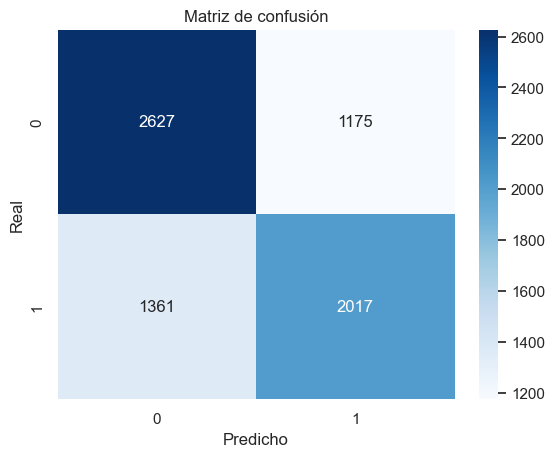

In [12]:
cm = confusion_matrix(y_test, preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de confusión')
plt.ylabel('Real')
plt.xlabel('Predicho')
plt.show()

In [13]:
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.66      0.69      0.67      3802
           1       0.63      0.60      0.61      3378

    accuracy                           0.65      7180
   macro avg       0.65      0.64      0.64      7180
weighted avg       0.65      0.65      0.65      7180



### Buscando los mejores parámetros

In [14]:

bst = XGBClassifier(objective='binary:logistic')


param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7, 9],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
    'min_child_weight': [1, 3, 5]
}


search = RandomizedSearchCV(
    estimator=bst,
    param_distributions=param_grid,
    n_iter=20,  
    scoring='f1',  # queremos optimizar f1
    cv=StratifiedKFold(n_splits=5),
    random_state=1234,
    n_jobs=-1,
    verbose=1
)


search.fit(X_train, y_train)


best_bst = search.best_estimator_
print("Mejores parámetros:", search.best_params_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Mejores parámetros: {'subsample': 0.9, 'n_estimators': 300, 'min_child_weight': 3, 'max_depth': 9, 'learning_rate': 0.2, 'colsample_bytree': 0.9}


In [15]:
best_bst.fit(X_train, y_train)
preds = best_bst.predict(X_test)

### Confusion matrix

              precision    recall  f1-score   support

           0       0.84      0.82      0.83      3802
           1       0.81      0.83      0.82      3378

    accuracy                           0.83      7180
   macro avg       0.82      0.83      0.82      7180
weighted avg       0.83      0.83      0.83      7180



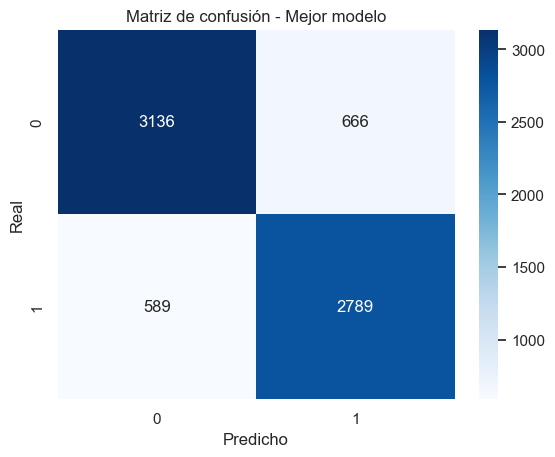

In [16]:
preds_best = best_bst.predict(X_test)


print(classification_report(y_test, preds_best))


cm_best = confusion_matrix(y_test, preds_best)
sns.heatmap(cm_best, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de confusión - Mejor modelo')
plt.ylabel('Real')
plt.xlabel('Predicho')
plt.show()

### Métodos locales: SHAP

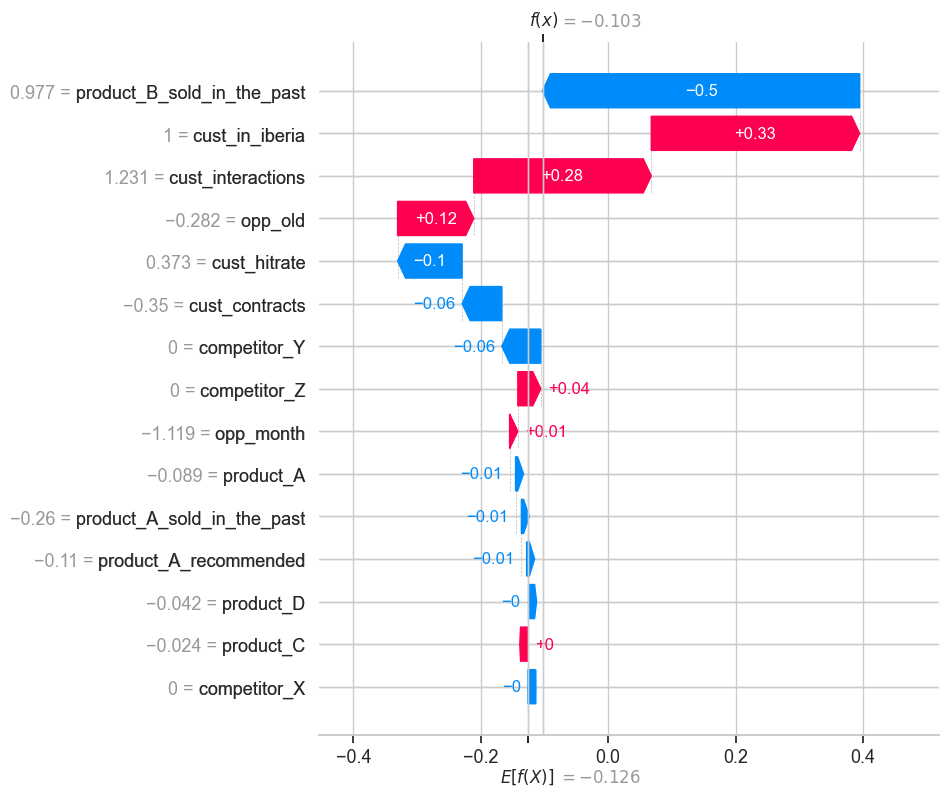

In [41]:
explainer = shap.TreeExplainer(best_bst)

explanation = explainer(X_test.iloc[[123]])  
shap.waterfall_plot(explanation[0], max_display=len(X_test.columns))

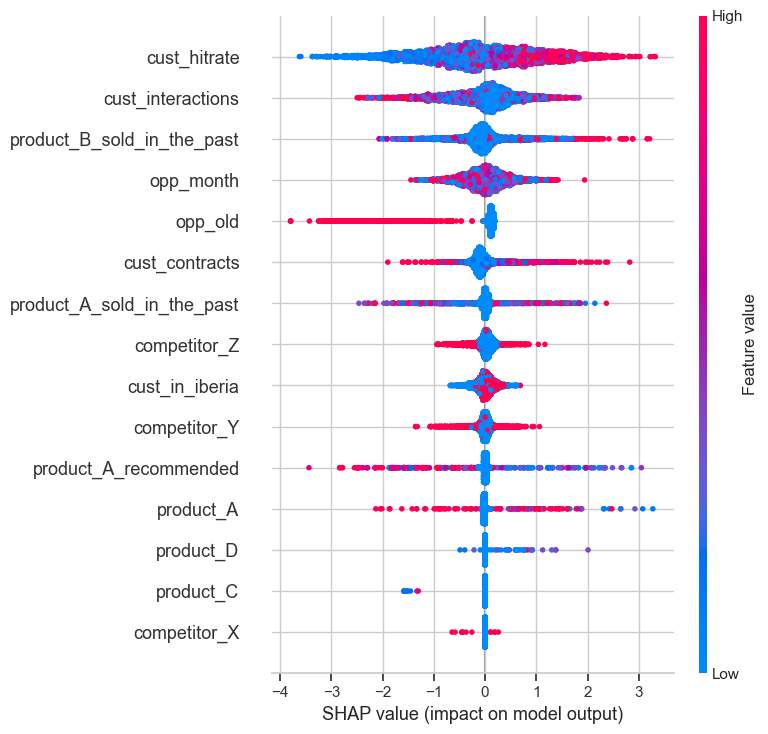

In [22]:
explainer = shap.TreeExplainer(best_bst)

shap_values = explainer.shap_values(X_test)

feature_names = X_test.columns.tolist()


# Si es clasificación binaria, XGBoost devuelve una lista de arrays
# shap_values[0] = clase 0, shap_values[1] = clase 1
# Usamos la clase positiva (1)
if isinstance(shap_values, list):
    shap_values = shap_values[1]  # Tomamos la clase 1 (ganado)

# Muestra la importancia y la dirección de las variables
shap.summary_plot(shap_values, X_test, feature_names=feature_names)

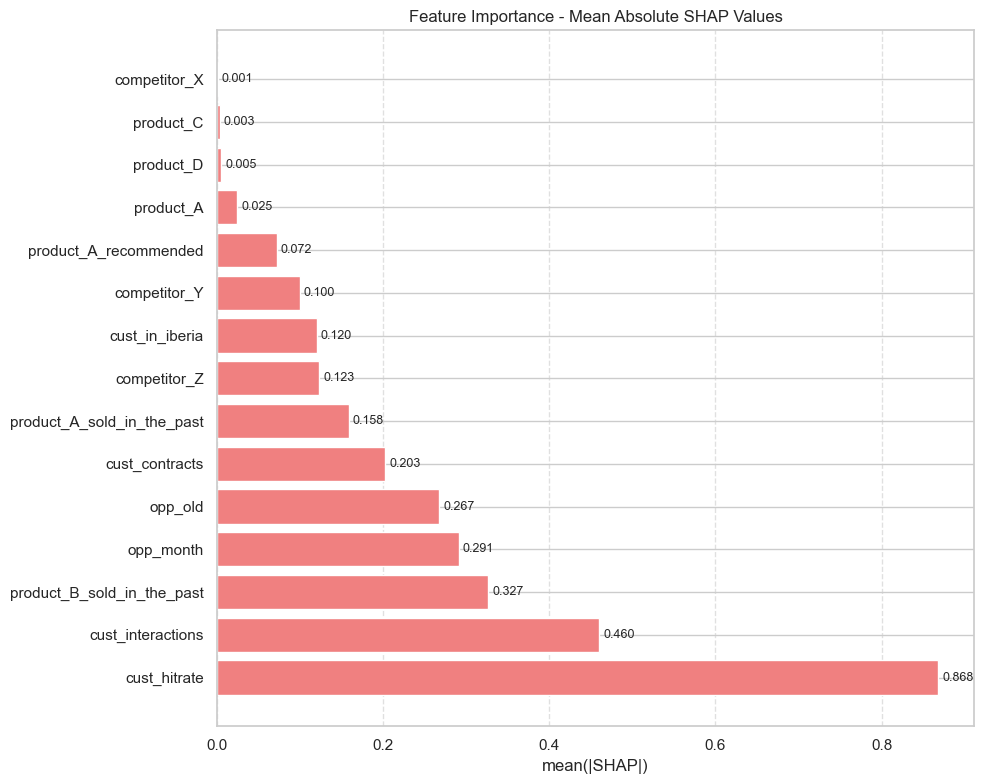

In [23]:
# Promedio de los valores absolutos de SHAP sobre todas las instancias
mean_abs_shap = np.abs(shap_values).mean(axis=0)


feature_names = X_test.columns if hasattr(X_test, 'columns') else [f"Feature_{i}" for i in range(X_test.shape[1])]
importance_df = pd.DataFrame({
    'feature': feature_names,
    'mean_abs_shap': mean_abs_shap
}).sort_values('mean_abs_shap', ascending=False)

plt.figure(figsize=(10, 8))
bars = plt.barh(importance_df['feature'], importance_df['mean_abs_shap'], color='lightcoral')

for bar in bars:
    width = bar.get_width()
    plt.text(width + 0.005, bar.get_y() + bar.get_height()/2, f'{width:.3f}', 
             ha='left', va='center', fontsize=9)

plt.xlabel('mean(|SHAP|)')
plt.title('Feature Importance - Mean Absolute SHAP Values')
plt.grid(True, axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

#### Ice

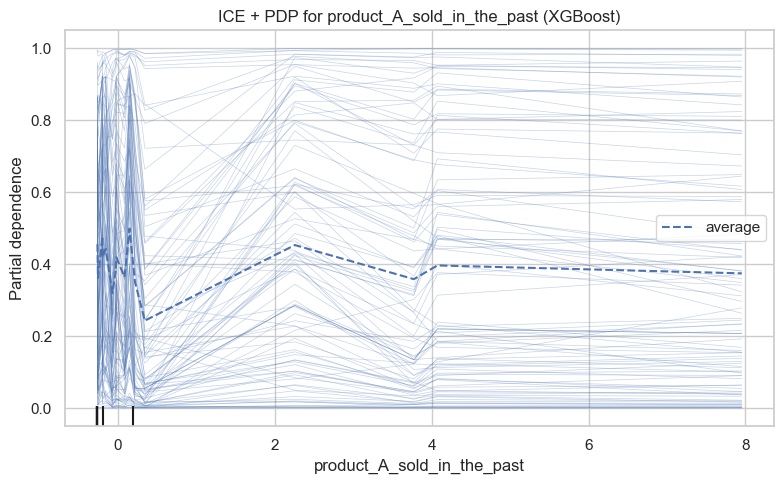

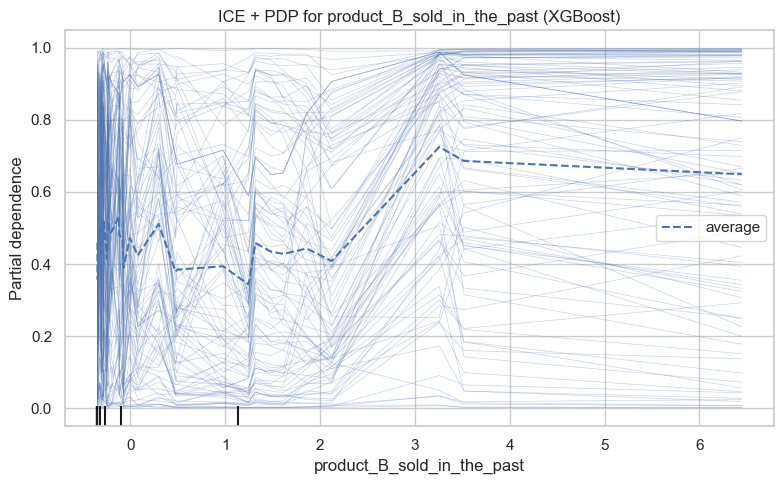

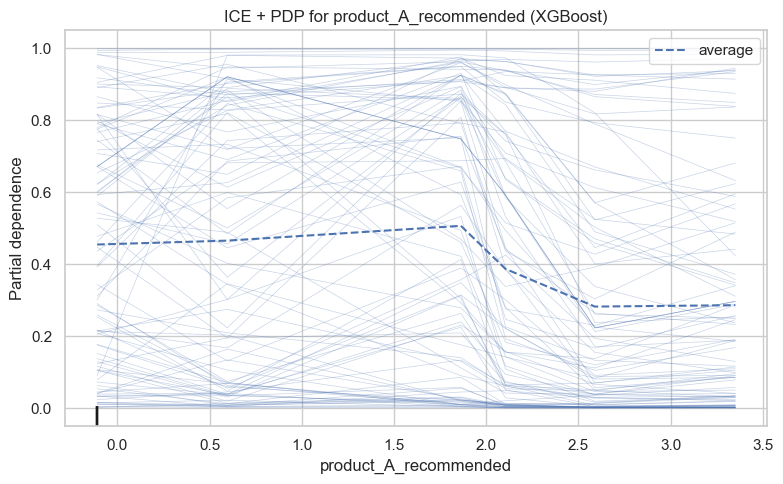

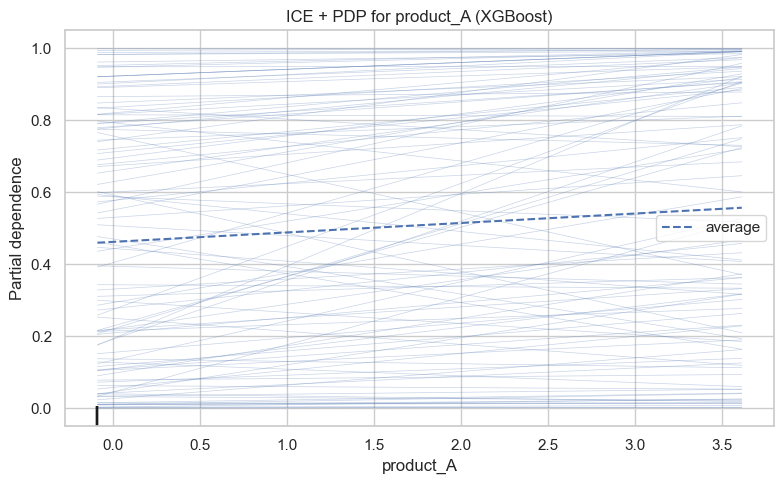

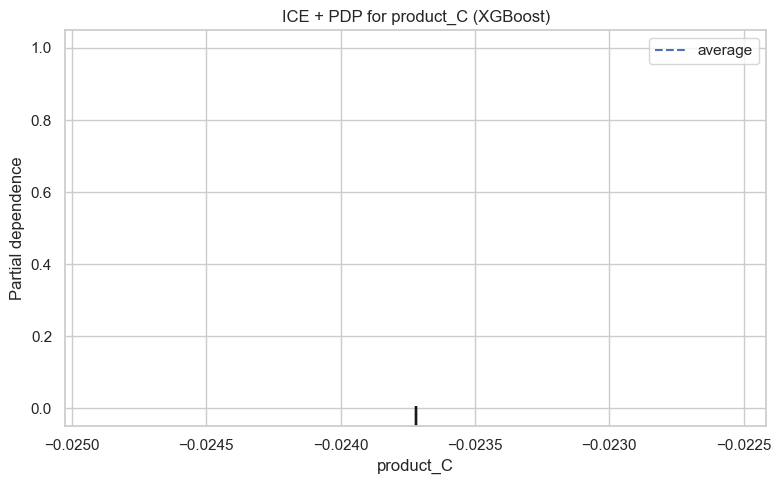

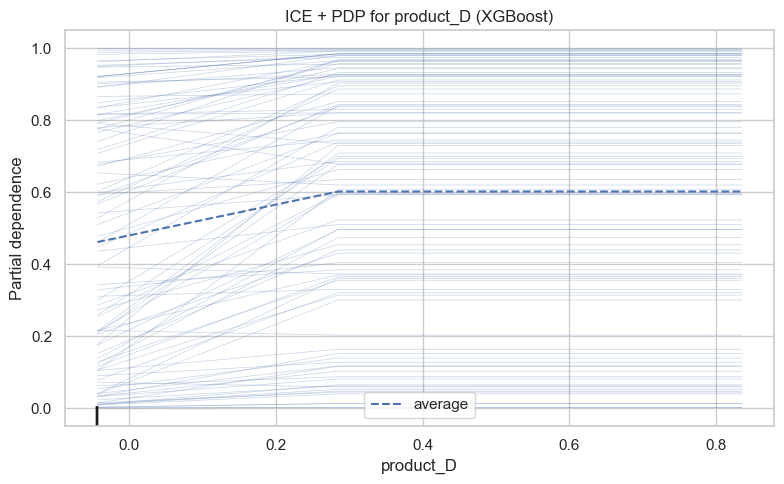

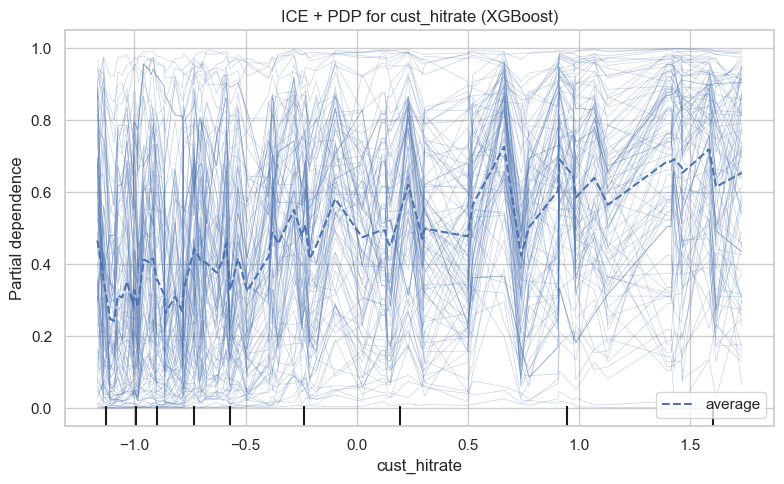

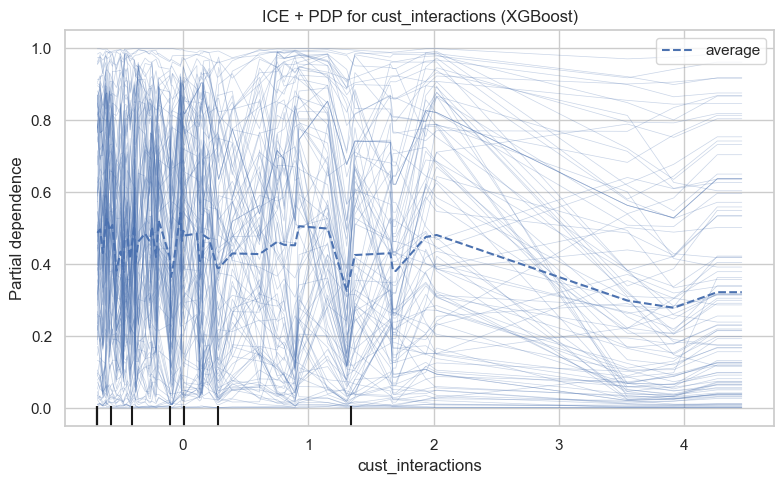

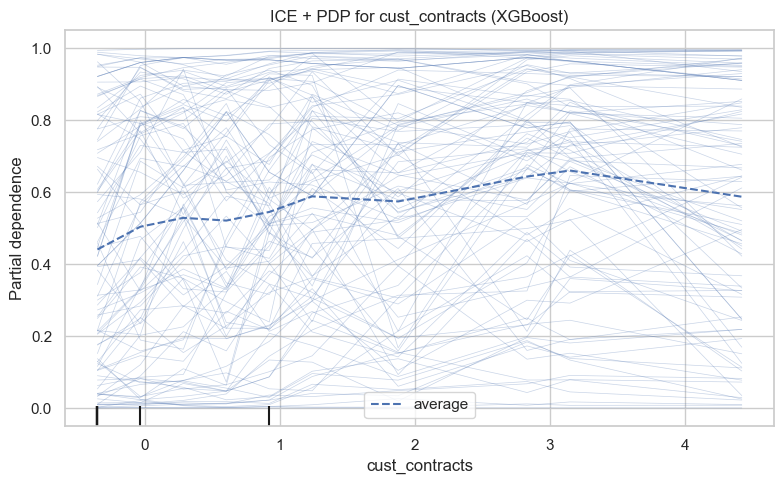

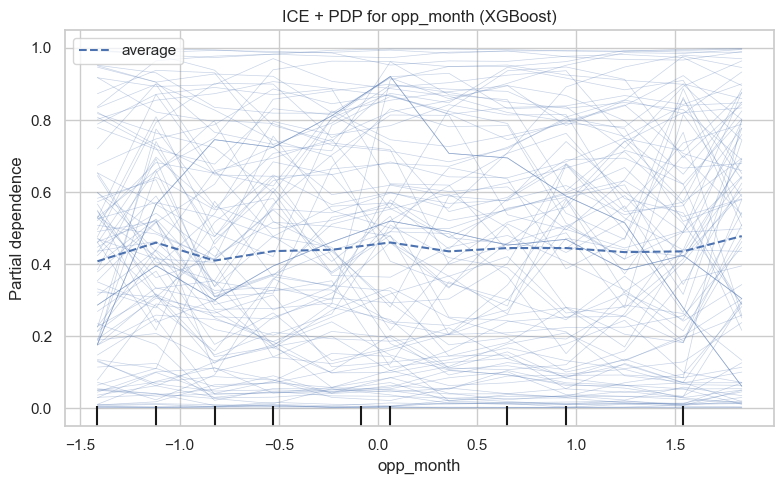

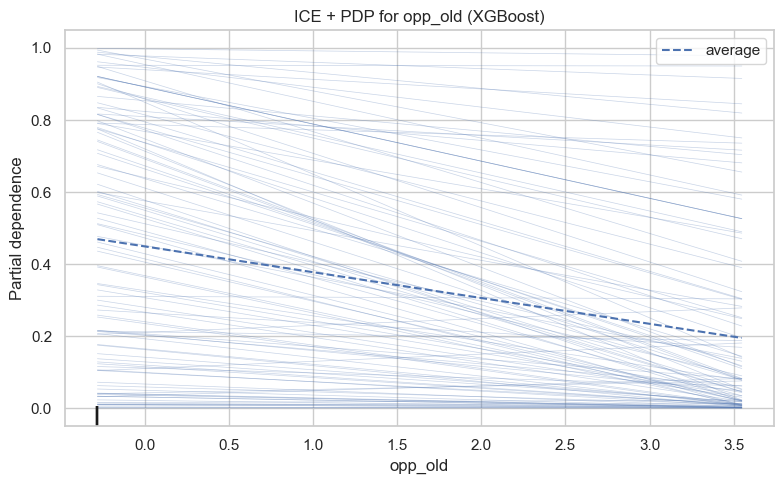

In [24]:
continuous_features = [
    'product_A_sold_in_the_past',
    'product_B_sold_in_the_past',
    'product_A_recommended',
    'product_A',
    'product_C',
    'product_D',
    'cust_hitrate',
    'cust_interactions', 
    'cust_contracts',  
    'opp_month', 
    'opp_old'
]

# Cogemos solo 100 observaciones para que se pueda ver bien
X_sample = X_test.sample(100, random_state=1234)

# ICE + PDP para cada variable
for feature in continuous_features:
    fig, ax = plt.subplots(figsize=(8, 5))
    
    PartialDependenceDisplay.from_estimator(
        best_bst,
        X_sample,
        features=[feature],
        kind='both',      
        ax=ax
    )
    
    ax.set_title(f"ICE + PDP for {feature} (XGBoost)")
    ax.set_ylabel("Predicted Probability (Won)")
    plt.tight_layout()
    plt.show()

### Métodos globales

#### Permutation Feature Importance 

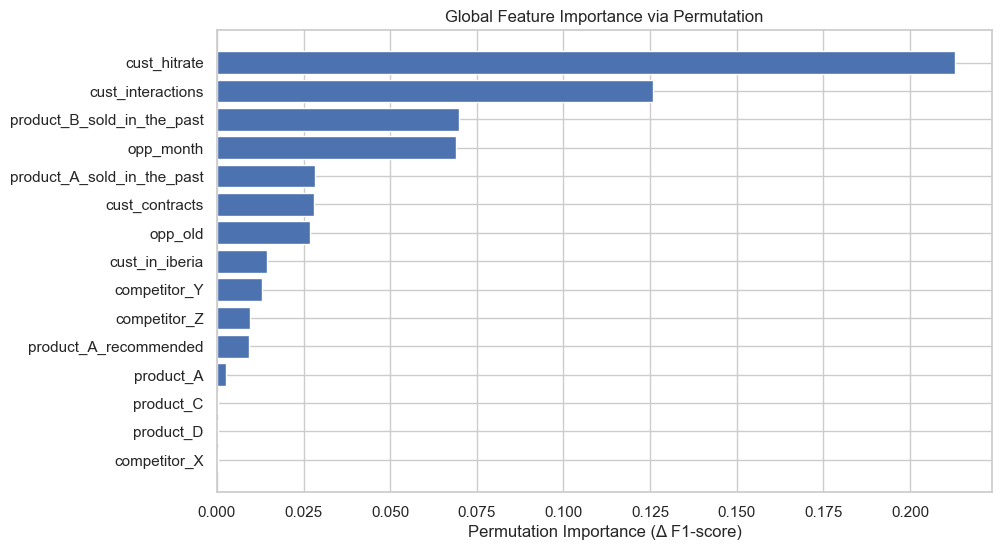

In [25]:
# calcular la diferencia del f1 si permutamos cada variable
perm_imp = permutation_importance(
    best_bst, 
    X_test, 
    y_test, 
    n_repeats=5, 
    random_state=1234,
    scoring='f1' 
)


perm_imp_df = pd.DataFrame({
    'feature': feature_names,
    'importance': perm_imp.importances_mean,
    'std': perm_imp.importances_std
}).sort_values('importance', ascending=False)


plt.figure(figsize=(10, 6))
plt.barh(perm_imp_df['feature'], perm_imp_df['importance'])
plt.xlabel('Permutation Importance (Δ F1-score)')
plt.title('Global Feature Importance via Permutation')
plt.gca().invert_yaxis()
plt.show()

#### Ale

In [26]:
# Función de predicción que acepta modelo y datos
def predict_fn(model, X):
    return model.predict_proba(X)[:, 1]


explainer = dx.Explainer(
    model=best_bst,
    data=X_test,
    predict_function=predict_fn 
)

# ALE
ale_obj = explainer.model_profile(type='accumulated', variables=['cust_interactions'])
ale_obj.plot()

Preparation of a new explainer is initiated

  -> data              : 7180 rows 15 cols
  -> target variable   : Not specified!
  -> model_class       : xgboost.sklearn.XGBClassifier (default)
  -> label             : Not specified, model's class short name will be used. (default)
  -> predict function  : <function predict_fn at 0x0000020D65A579C0> will be used
  -> predict function  : Accepts pandas.DataFrame and numpy.ndarray.
  -> predicted values  : min = 0.000148, mean = 0.473, max = 1.0
  -> model type        : classification will be used (default)
  -> residual function : difference between y and yhat (default)
  -> model_info        : package xgboost

A new explainer has been created!


Calculating accumulated dependency:   0%|          | 0/1 [00:00<?, ?it/s]c:\Users\lihao\OneDrive\桌面\UNI\2n\Q3\IAA\.venv\Lib\site-packages\dalex\model_explanations\_aggregated_profiles\utils.py:85: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  apply(lambda point: (point['_yhat_'] * point['_w_']).sum() / point['_w_'].sum() \
c:\Users\lihao\OneDrive\桌面\UNI\2n\Q3\IAA\.venv\Lib\site-packages\tqdm\std.py:917: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after gr

In [27]:
# Para todas las variables continuas
ale_obj = explainer.model_profile(
    type='accumulated',
    variables=[    'product_A_sold_in_the_past',
    'product_B_sold_in_the_past',
    'product_A_recommended',
    'product_A',
    'product_C',
    'product_D',
    'cust_hitrate',
    'cust_interactions', 
    'cust_contracts',  
    'opp_month', 
    'opp_old']
)
ale_obj.plot()

Calculating accumulated dependency:   0%|          | 0/11 [00:00<?, ?it/s]c:\Users\lihao\OneDrive\桌面\UNI\2n\Q3\IAA\.venv\Lib\site-packages\dalex\model_explanations\_aggregated_profiles\utils.py:85: FutureWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.

Calculating accumulated dependency:  18%|█▊        | 2/11 [00:00<00:00, 14.60it/s]c:\Users\lihao\OneDrive\桌面\UNI\2n\Q3\IAA\.venv\Lib\site-packages\dalex\model_explanations\_aggregated_profiles\utils.py:85: FutureWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or exp